In [1]:
import numpy as np, pandas as pd
from sklearn.cluster import k_means
import scipy.io
from tqdm import tqdm
from collections import Counter
from scipy.optimize import linear_sum_assignment
from scipy.sparse.linalg import svds
import itertools
from time import time
import matplotlib.pyplot as plt
import os

In [2]:
c = 100
e = 0.3333333333333

In [3]:
def objective(A, X):  
    X_norm = X / np.sqrt(np.count_nonzero(X, axis=0))
    return np.linalg.norm(A - np.dot(np.dot(X_norm, X_norm.T), A)) ** 2/ np.linalg.norm(A) ** 2

def accuracy(X_true, X_pred):
    k = X_true.shape[1]
    cost_mtx = np.zeros((k, k))
    for i, j in itertools.product(range(k), repeat=2):
        cost_mtx[i][j] = np.sum(X_true[:, i] * X_pred[:, j])
    # Hungarian algorithm to choose best matching
    row_ind, col_ind = linear_sum_assignment(-cost_mtx)
    
    return cost_mtx[row_ind, col_ind].sum() / X_true.shape[0]

def random_sampling(X, r):  # Randomized Sampling
    p = np.apply_along_axis(lambda x: np.linalg.norm(x) ** 2, axis=1, arr=X) / np.linalg.norm(X) ** 2
    sigma = np.zeros((X.shape[0], r))
    S = np.zeros((r, r))
    to_sample = np.vstack([np.arange(r), np.random.choice(np.arange(p.shape[0]), size=r, p=p)])

    def worker(x):
        t, j = x[0], x[1]
        sigma[j, t] = 1
        S[t, t] = 1 / np.sqrt(r * p[j])

    np.apply_along_axis(worker, 0, to_sample)
    return sigma, S

def fast_frob_SVD(A, k, e):  
    n = A.shape[1]
    r = k + int(k / e + 1)
    R = np.random.randn(n, r)
    Y = np.dot(A, R)
    V = np.linalg.qr(Y)[0]
    return svds(np.dot(V.T, A), k, return_singular_vectors='vh')[2].T



# Different Randomized Methods:
def approximate_SVD(A, k, r): 
    Z = fast_frob_SVD(A, r, e)
    return np.dot(A, Z)


def exact_SVD(A, k, r):  
    Z = svds(A, r, return_singular_vectors='vh')[2].T    
    return np.dot(A, Z)


def random_projection(A, k, r):  
    n = A.shape[1]
    R = np.random.choice([-1., 1.], size=(n, r)) / np.sqrt(r)
    return np.dot(A, R)


def rsampling_approximate_SVD(A, k, r):  
    Z = fast_frob_SVD(A, k, e)
    O, S = random_sampling(Z, r)
    return np.dot(A, np.dot(O, S))


def rsampling_exact_SVD(A, k, r):  
    Z = svds(A, k, return_singular_vectors='vh')[2].T
    O, S = random_sampling(Z, r)
    return np.dot(A, np.dot(O, S))


def apply_method(A, k, r, name):
    methods = dict(ApproxSVD = approximate_SVD, 
                   SVD = exact_SVD, 
                   RP = random_projection, 
                   SamplApproxSVD = rsampling_approximate_SVD, 
                   SamplSVD = rsampling_exact_SVD,
                   Raw = lambda A, k, r: A)
    return methods[name](A, k, r)

In [4]:
def get_usps():
    data = scipy.io.loadmat('usps_all.mat')['data']
    data = np.transpose(data, (2, 1, 0)).astype(np.int32)
    k = data.shape[0]
    samples = data.shape[1]
    data = data.reshape((k * samples, data.shape[2]))
    ids_true = np.outer(np.ones(samples, dtype=np.int32), np.arange(k)).T.reshape((samples * k))
    X_true = np.eye(k)[ids_true]
    return data / 255., X_true, k

In [5]:
def get_synth(dim=2000, k=5, samples=200, side=200.):
    centers = np.random.uniform(high=side, size=(k, dim))
    data = np.random.normal(centers, size=(samples, k, dim))
    data = np.transpose(data, (1, 0, 2)).reshape(samples * k, dim)
    ids_true = np.outer(np.ones(samples, dtype=np.int32), np.arange(k)).T.reshape((samples * k))
    X_true = np.eye(k)[ids_true]
    return data, X_true, k

In [6]:
def get_coil20():
    data = np.zeros((1440, 128*128))
    for fname in os.listdir("coil-20-proc"):
        l, r = fname.split('__')
        cl = int(l[3:]) - 1
        i = int(r.split('.')[0])
        img = PIL.Image.open("coil-20-proc/" + fname)
        data[cl*72 + i] = np.asarray(img).reshape(128*128)
    ids_true = np.outer(np.ones(72, dtype=np.int32), np.arange(20)).T.reshape((1440))
    X_true = np.eye(20)[ids_true]
    return data / 255., X_true, 20

In [7]:
methods = ["ApproxSVD", "SVD", "RP", "SamplApproxSVD", "SamplSVD", "Raw"]
results = {}
for method in methods:
    results[method] = dict(time=[], objective=[], accuracy=[])

In [8]:
data, X_true, k = get_usps()

In [110]:
for method in methods:
    for dim in tqdm(range(5, 100, 5)):
        acc_temp = []
        obj_temp = []
        time_temp = []
        for _ in range(5):
            start = time()
            r_data = apply_method(data, k=k, r=dim, name=method)
            pred_centers, ids, inertia = k_means(r_data, n_clusters=k, init='random', n_init=5, max_iter=500)
            time_temp.append(time() - start)
            X_pred = np.eye(k)[ids]
            acc_temp.append(accuracy(X_true, X_pred))
            obj_temp.append(objective(data, X_pred))
        results[method]["time"].append(np.mean(time_temp))
        results[method]["objective"].append(np.mean(obj_temp))
        results[method]["accuracy"].append(np.mean(acc_temp))
        if method == "Raw":
            break

  0%|          | 0/19 [00:00<?, ?it/s]

In [279]:
objective(data, X_true)

0.4872395443584611

In [280]:
methods = ["ApproxSVD", "SVD", "RP", "Sampl/ApproxSVD", "Sampl/SVD"]
labels = ["Running Time (seconds)", "Normalize objective value", "Accuracy"]

0.1272250561227217

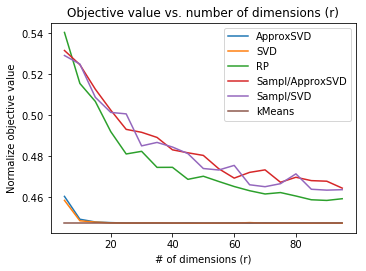

In [129]:
# plt.close()
var = "objective"
plt.figure(figsize=(5, 3.5))
plt.plot(np.arange(5, 100, 5), results["ApproxSVD"][var], label="ApproxSVD")
plt.plot(np.arange(5, 100, 5), results["SVD"][var], label="SVD")
plt.plot(np.arange(5, 100, 5), results["RP"][var], label="RP")
plt.plot(np.arange(5, 100, 5), results["SamplApproxSVD"][var], label="Sampl/ApproxSVD")
plt.plot(np.arange(5, 100, 5), results["SamplSVD"][var], label="Sampl/SVD")
plt.plot(np.arange(5, 100, 5), np.repeat(np.mean(results["Raw"][var]), 19), label="kMeans")
plt.legend(loc="upper right")
# plt.gca().set_aspect('equal')
plt.tight_layout()
plt.xlabel("# of dimensions (r)")
plt.ylabel(labels[1])
plt.title("Objective value vs. number of dimensions (r)")
plt.show()
# plt.savefig("imgs/1_obj.eps", format='eps', dpi=300., bbox_inches="tight")